# Feature Analysis

In [1]:
from pyspark import SparkContext
from scipy import stats
from math import ceil
import json
import utils
import pprint
pp = pprint.PrettyPrinter(indent=4)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns

sc = SparkContext("local[*]", "ADA")
sc.defaultParallelism

8

In [2]:
rdd_features = sc.textFile('data/spark/features/').map(json.loads)
rdd_features.count()
rdd_features.first()

{'Features': {'averageResubmitTime': 0.0,
  'firstProblemGrade': 10.0,
  'increaseGrade': 0.0,
  'lastProblemGrade': 10.0,
  'numberOfForumEvent': 0,
  'numberOfProblemEvent': 1,
  'numberOfVideoEvent': 12,
  'numberOfVideosBeforeFirstProblem': 7,
  'patternString': 'VVVVVVVVVVVVP',
  'percentageIncreased': 0.0,
  'proportionOfForum': 0.0,
  'proportionOfProblem': 0.07692307692307693,
  'proportionOfVideo': 0.9230769230769231,
  'repeatedVideoBeforeFirstProblem': 1.0,
  'timeBetweenFirstAndLastProblem': 0.0,
  'timeBetweenStartAndFirstProblem': 1.647199074074074,
  'timeBetweenStartAndLastProblem': 1.647199074074074,
  'timeFromFirstToHardCloseTime': 6.934513888888889,
  'timeFromLastToHardCloseTime': 6.934513888888889,
  'timeFromStartToHardCloseTime': 8.581712962962962,
  'watchedVideoAfterFirstProblem': 0.0},
 'Pattern': 'VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVP',
 'PatternC': 'VVVVVVVVVVVVP',
 'ProblemID': 21,
 'S

In [3]:
df = pd.DataFrame(rdd_features.map(lambda x: x['Features']).collect())
print(df.shape)
df.head()

(41791, 21)


,averageResubmitTime,firstProblemGrade,increaseGrade,lastProblemGrade,numberOfForumEvent,numberOfProblemEvent,numberOfVideoEvent,numberOfVideosBeforeFirstProblem,patternString,percentageIncreased,...,proportionOfProblem,proportionOfVideo,repeatedVideoBeforeFirstProblem,timeBetweenFirstAndLastProblem,timeBetweenStartAndFirstProblem,timeBetweenStartAndLastProblem,timeFromFirstToHardCloseTime,timeFromLastToHardCloseTime,timeFromStartToHardCloseTime,watchedVideoAfterFirstProblem
0,0.000000,10.00,0.0,10.00,0,1,12,7,VVVVVVVVVVVVP,0.000000,...,0.076923,0.923077,1.0,0.000000,1.647199,1.647199,6.934514,6.934514,8.581713,0.0
1,0.004576,9.82,1.0,10.00,0,4,27,7,VVVVVVVVVVVVVVVVVVVVVVVVVVVPPPP,0.999944,...,0.129032,0.870968,1.0,0.013727,3.382581,3.396308,8.557303,8.543576,11.939884,0.0
2,0.005995,9.33,1.0,10.00,0,2,0,0,PP,0.999985,...,1.000000,0.000000,0.0,0.005995,0.000000,0.005995,1.028090,1.022095,1.028090,0.0
3,0.202402,9.12,1.0,9.98,0,3,0,0,PPP,0.977261,...,1.000000,0.000000,0.0,0.404803,0.000000,0.404803,3.101609,2.696806,3.101609,0.0
4,0.012755,7.33,1.0,10.00,0,2,7,7,VVVVVVVPP,0.999996,...,0.222222,0.777778,0.0,0.012755,3.643322,3.656076,2.526030,2.513275,6.169352,0.0


# Cleaning

In [4]:
#df = df[df.timeBetweenStartAndLastProblem<15]

In [5]:
#df = df[df.totalNumberOfProblemSubmissions>1]

# Kmeans

In [6]:
# remove features linked to grades
FEATURES = list(df
    #.drop('firstProblemGrade', 1)
    #.drop('lastProblemGrade', 1)
    #.drop('percentageIncreased', 1) 
    .drop('patternString', 1)
    #.drop('increaseGrade', 1)
    .columns
)

FEATURE_AVG = {}
FEATURE_STD = {} 
for feature in FEATURES:
    FEATURE_AVG[feature] = df[feature].mean()
    FEATURE_STD[feature] = df[feature].std()

df_kmeans = pd.DataFrame([])
for feature in FEATURES:
    df_kmeans[feature] = df[feature].apply(lambda x: (x-FEATURE_AVG[feature])/FEATURE_STD[feature])

print(df_kmeans.shape)
df_kmeans.head()

(41791, 20)


,averageResubmitTime,firstProblemGrade,increaseGrade,lastProblemGrade,numberOfForumEvent,numberOfProblemEvent,numberOfVideoEvent,numberOfVideosBeforeFirstProblem,percentageIncreased,proportionOfForum,proportionOfProblem,proportionOfVideo,repeatedVideoBeforeFirstProblem,timeBetweenFirstAndLastProblem,timeBetweenStartAndFirstProblem,timeBetweenStartAndLastProblem,timeFromFirstToHardCloseTime,timeFromLastToHardCloseTime,timeFromStartToHardCloseTime,watchedVideoAfterFirstProblem
0,-0.233891,0.574578,-0.828860,0.356733,-0.541524,-0.636351,1.102605,1.075502,-0.788421,-0.706276,-0.951226,1.253553,1.456769,-0.256590,-0.410946,-0.463401,-0.116426,-0.062811,-0.407170,-0.195665
1,-0.225435,0.480545,1.206447,0.356733,-0.541524,1.872413,3.466026,1.075502,1.346666,-0.706276,-0.803338,1.097638,1.456769,-0.240009,0.110975,0.049984,0.298557,0.353341,0.343429,-0.195665
2,-0.222811,0.224568,1.206447,0.356733,-0.541524,0.199904,-0.788131,-1.298321,1.346753,-0.706276,1.668508,-1.508367,-0.686434,-0.249348,-0.906345,-0.945114,-1.626830,-1.591940,-2.095513,-0.195665
3,0.140158,0.114863,1.206447,0.339739,-0.541524,1.036158,-0.788131,-1.298321,1.298232,-0.706276,1.668508,-1.508367,-0.686434,0.232381,-0.906345,-0.828059,-1.096585,-1.158809,-1.632052,-0.195665
4,-0.210319,-0.820239,1.206447,0.356733,-0.541524,0.199904,0.314799,1.075502,1.346776,-0.706276,-0.538861,0.818806,-0.686434,-0.241183,0.189394,0.126229,-1.243773,-1.206276,-0.946367,-0.195665


In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:

    # Initialize the model with n_clusters
    model = KMeans(n_clusters=n_clusters)
    labels = model.fit_predict(df_kmeans)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    
    # THIS NEED MORE THAN 16G memory
    # silhouette_avg = silhouette_score(df_kmeans, labels)
    silhouette_avg = 0
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0
For n_clusters = 3 The average silhouette_score is : 0
For n_clusters = 4 The average silhouette_score is : 0
For n_clusters = 5 The average silhouette_score is : 0


# Exploration for K = 3

In [8]:
def runKMean(k = 3):
    print('running Kmeans algorithm')
    print('\n___________________\n')

    kmeansModel = KMeans(n_clusters=k)
    kmeansModel.fit(df_kmeans)

    centers = kmeansModel.cluster_centers_
    labels = kmeansModel.labels_
    

    print('student repartition')
    for index in range(len(centers)):
        print(sum([label==index for label in labels])/len(labels),end='\t')
    print('\n___________________\n')

    #for index in range(len(FEATURES)):
    #    feature = FEATURES[index]
    #    print(feature)
    #    for center in centers:
    #        print((center[index]*FEATURE_STD[feature])+FEATURE_AVG[feature],end='\t')
    #    print('\n') 


    print('___________________\n')
    return labels

labels = runKMean(3)

running Kmeans algorithm

___________________

student repartition
0.312411763298	0.285659591778	0.401928644924	
___________________

___________________



# Sankey for changes of navigation pattern type

In [9]:
students = (rdd_features
    .map(lambda x : (x['StudentID'], utils.reOrderProblemID(x['ProblemID'])))
).collect()

s = {}
for i, student in enumerate(students):
    s[student[0]] = s.get(student[0],{})
    s[student[0]][student[1]] = str(labels[i])

t = {}
for student in s.keys(): 
    t[student] = ('1_' + s[student].get(1,'D') + ','
        + '2_' + s[student].get(2,'D') + ','
        + '3_' + s[student].get(3,'D') + ','
        + '4_' + s[student].get(4,'D') + ','
        + '5_' + s[student].get(5,'D') + ','
        + '6_' + s[student].get(6,'D'))

counts = {}
for path in t.values():
    counts[path] = 1 + counts.get(path,0)

k = list(counts.keys())
for path in k:
    if counts[path] < 0: 
        del counts[path]

In [10]:
from collections import Counter, OrderedDict

COLOR = {'0':'blue', '1':'green', '2': 'red', 'D': 'black'}

def create_json_file(final_patterns):
    json_file = {"sankey": OrderedDict()}
    json_file['sankey']['nodes'] = []
    json_file['sankey']['links'] = []
    
    for pattern, count in final_patterns.items():
        pattern_elements = pattern.split(',')
        
        for i in range(len(pattern_elements) - 1):
            n_nodes = len(json_file['sankey']['nodes'])
            event_start = pattern_elements[i]
            event_start_idx = None
            event_end = pattern_elements[i + 1]
            event_end_idx = None
            
            # Check if these events already exist
            for idx, event in enumerate(json_file['sankey']['nodes']):
                if event['name'] == event_start:
                    event_start_idx = idx
                if event['name'] == event_end:
                    event_end_idx = idx
                    
            # If start event not found
            if event_start_idx == None:
                json_file['sankey']['nodes'].append({"name": event_start, "fill": COLOR[event_start[-1]]})
                event_start_idx = n_nodes
                n_nodes += 1
                
            # If loop
            if event_start == event_end:
                event_end_idx = event_start_idx
            # If end event not found
            elif event_end_idx == None:
                json_file['sankey']['nodes'].append({"name": event_end, "fill": COLOR[event_end[-1]]})
                event_end_idx = n_nodes
                n_nodes += 1

            # Check if source->target already exists
            for link in json_file['sankey']['links']:
                if link['source'] == event_start_idx and link['target'] == event_end_idx:
                    link['value'] += count
                    break
            else:
                json_file['sankey']['links'].append({
                    "source": event_start_idx,
                    "target": event_end_idx,
                    "value": count
                })

    return json_file

In [11]:
with open('sankey_data/strategies.json', 'w') as outfile:
    json.dump(create_json_file(counts), outfile)

# Interpretation:

## cluster 0:
students that tends to use the video a lot and a bit the forum. it is intersting to notice that they don't use the video after the 1st problem meaning that they probably understood the lesson well once the problem is done. This seems to be a cluster of "serious" & classical students that do everything in order and that do not go to the problem before knowing the lesson. It is also the students having the best grades.

## cluster 1: 
The students of that cluster mainly do not watch any videos. They also do not use a lot the forum and go directly to the problem. Thus they are very quick and have good grade (1st and last). Students that seem to already have the knowledge for this course and that might be here just for the certificat.

## cluster 2: 
Cluster of students having difficulties with the course. It can be seen with the grade (way lower in that cluster) & also by the big number of forum events proving that the students try to find answer that he do not have. In this cluster, students go to the problem several times and have to go back to the lesson (videos are watched after the first attemps) to try to address their shortcoming.

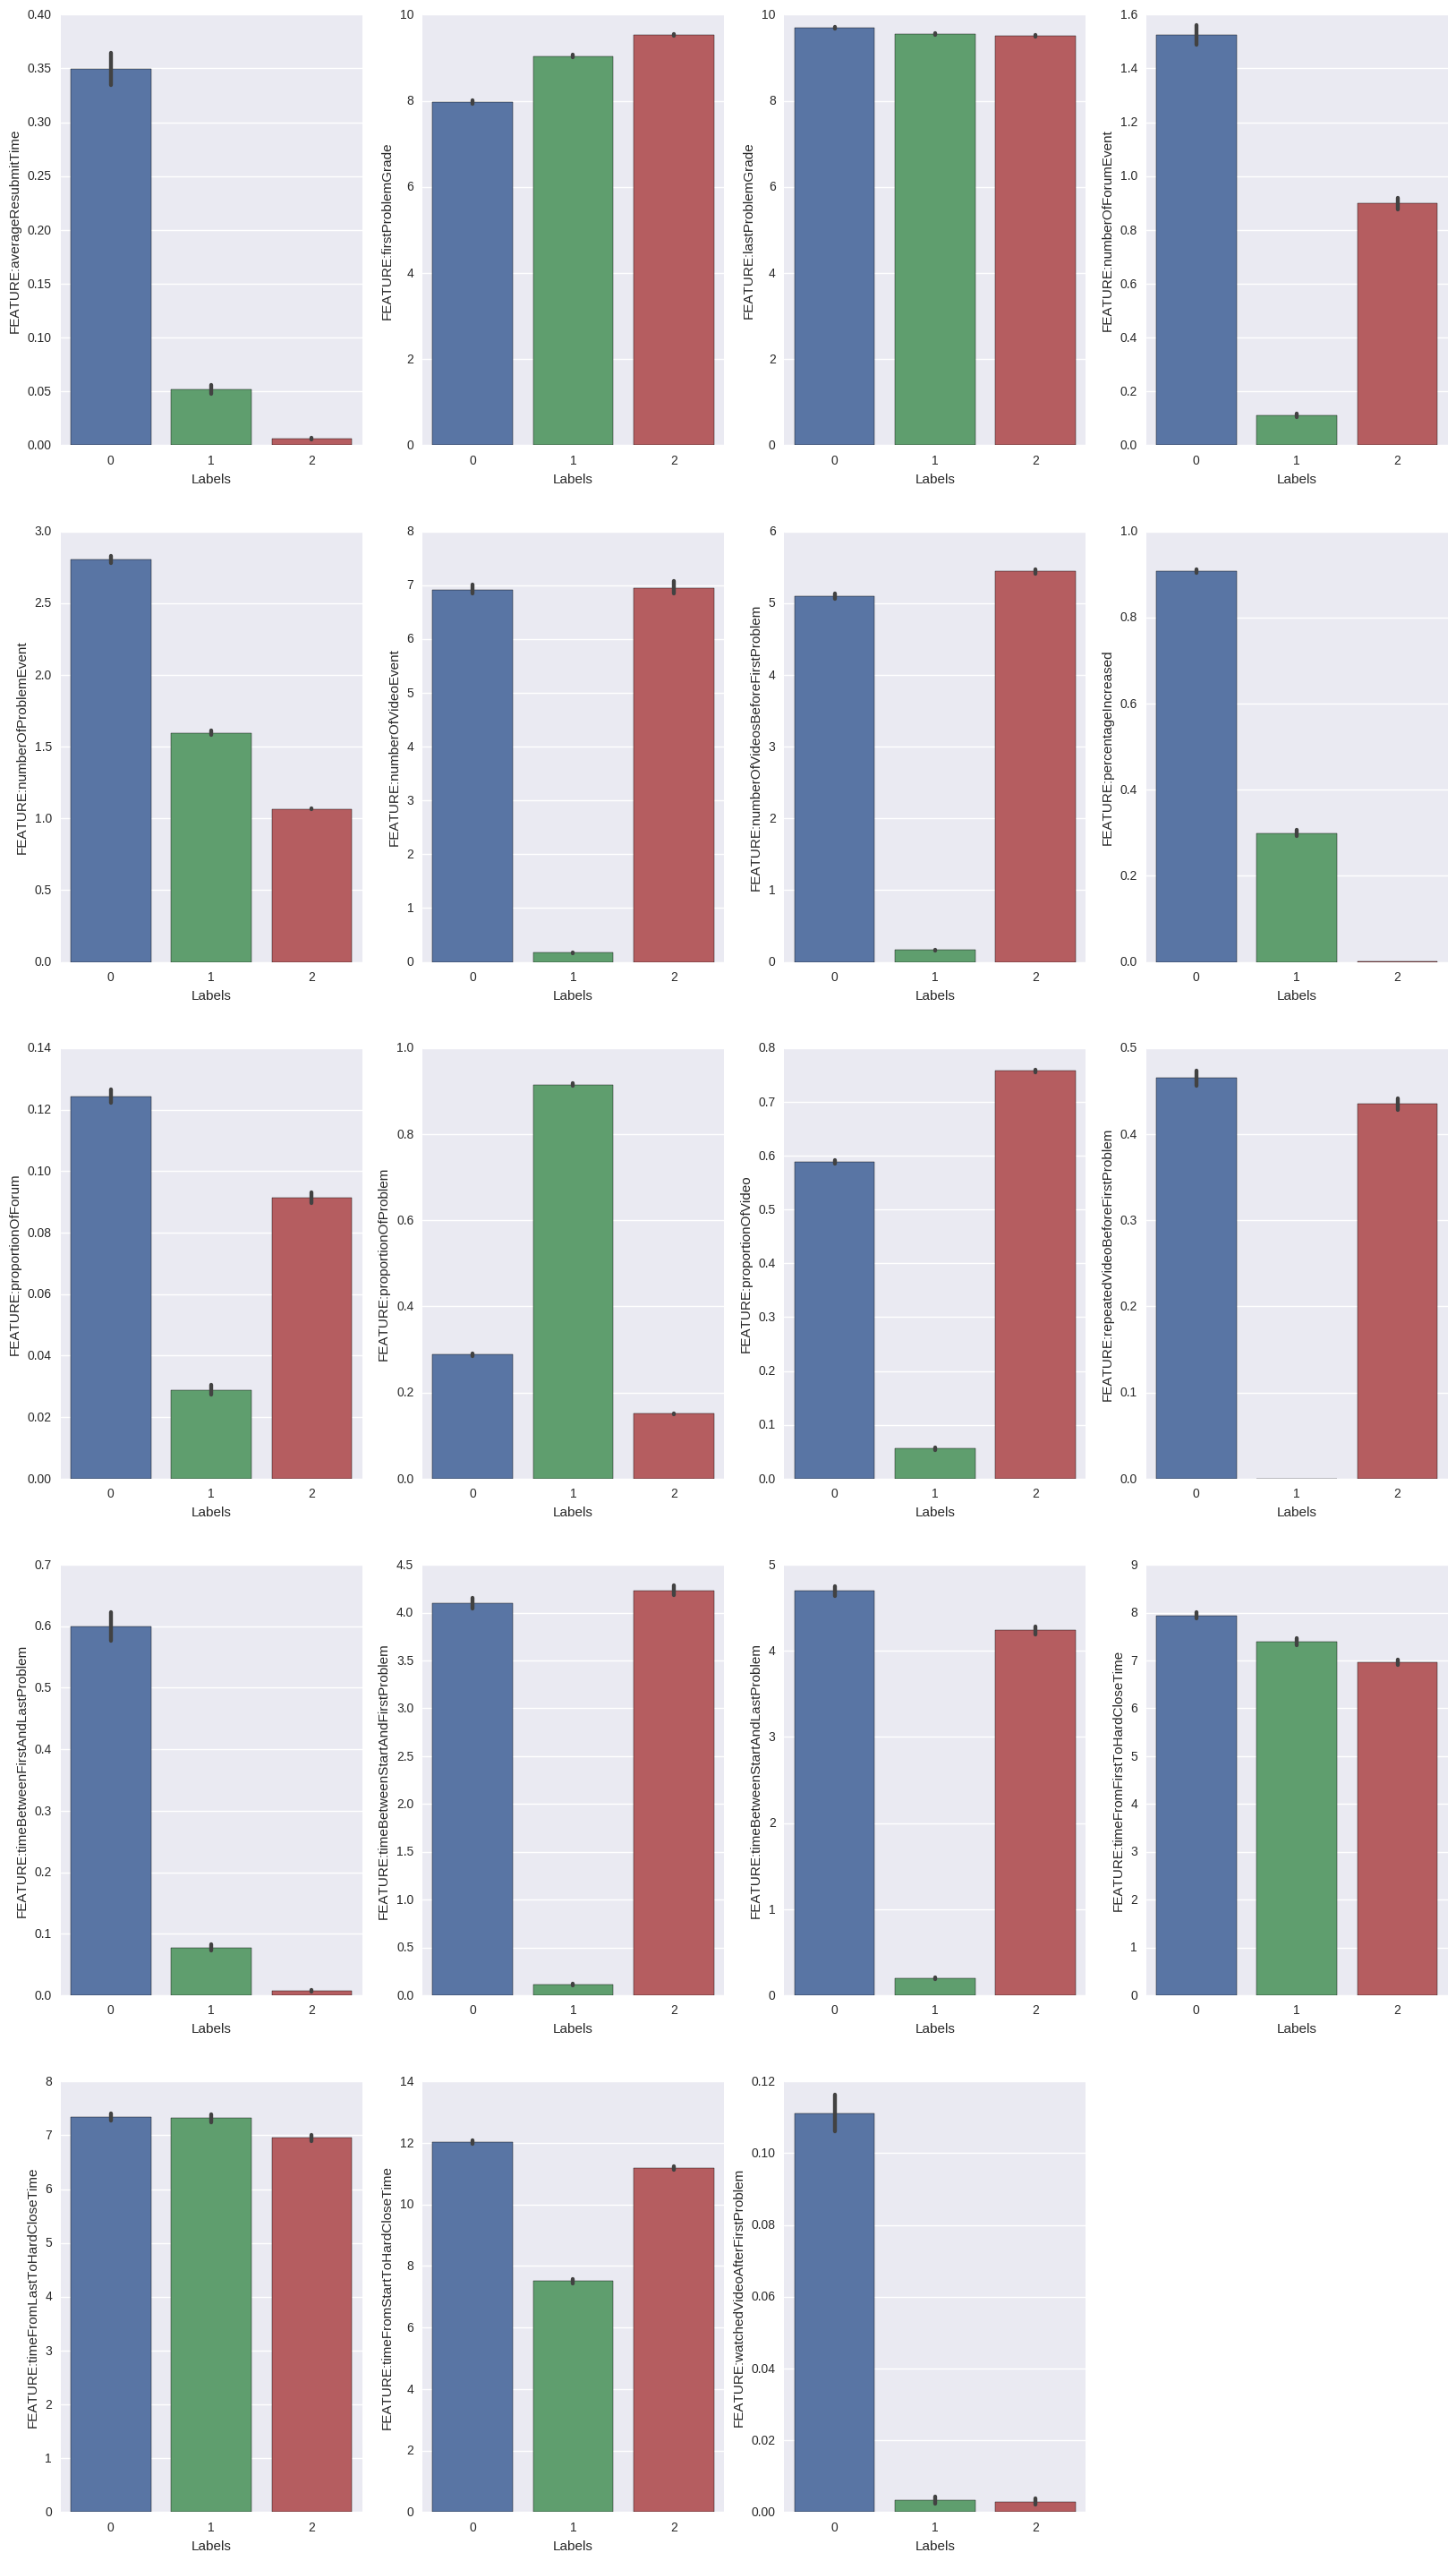

In [12]:
def displayGraph():
    d = df
    d['Labels'] = labels
            
    clusters = np.unique(labels)
    features = {}
    
    columns = list(df
        .drop('patternString', 1)
        .drop('increaseGrade', 1)
        .drop('Labels',1)
        .columns)
    
    plt.figure(figsize=(20,36))
    for i in range(len(columns)):
        plt.subplot(1+len(columns)/4, 4, 1 + i)
        sns.barplot(x='Labels', y=columns[i], data=d)
        plt.ylabel('FEATURE:' + columns[i])
    plt.show()
    
displayGraph()

In [13]:
def exploreClusters():
    for cluster in np.unique(labels):
        print("-------------- cluster ", cluster, " --------------")
        # get individual for that label
        df_label = df_kmean[ [label==cluster for label in labels] ]
        for index in df_label.columns:
            print(index, " :",  np.mean(df_label[index].values))

        print("\n")

In [14]:
def gradeDifference():
    clusters = np.unique(labels)
    grades = {}
    for cluster in clusters:
        grades[cluster] = df[ [label==cluster for label in labels] ].lastProblemGrade.values
    
    for i in clusters:
        for j in clusters[i+1:]:
            _, p =stats.ttest_ind(grades[i], grades[j])
            if (p < 0.01):
                print("grade difference statistically significant between cluster ", i, " and ", j)
                
gradeDifference()

grade difference statistically significant between cluster  0  and  1
grade difference statistically significant between cluster  0  and  2


# PCA 

In [15]:
from sklearn.decomposition import PCA

df_kmeans['labels'] = labels

# create pca model
# remove outliers -> grades that are below mean - 2*std
outlierLimit = np.mean(df.lastProblemGrade.values) - 2*np.std(df.lastProblemGrade.values)
df_pca = df_kmeans[df.lastProblemGrade > outlierLimit]

X = df_pca.drop('labels',1).values.tolist()
pca = PCA(n_components=9, whiten=True)
pca.fit(X)

print('________________\n')
for component in pca.components_[:4]:
    c_abs = [abs(c) for c in component]
    indexes = [i[0] for i in sorted(enumerate(c_abs), key=lambda x:-x[1])]
    for index in indexes[:3]:
        print(df_pca.columns[index], component[index])
    print(component)
    print('________________\n')

________________

proportionOfProblem -0.396601560758
numberOfVideosBeforeFirstProblem 0.376320435725
proportionOfVideo 0.358911064392
[ 0.05755406 -0.04754936  0.08897846 -0.00378043  0.21784118  0.07323597
  0.29739543  0.37632044  0.08777506  0.16682452 -0.39660156  0.35891106
  0.28467476  0.06799348  0.33288214  0.34138978  0.00789137 -0.00657708
  0.25428987  0.064666  ]
________________

increaseGrade 0.438237880205
percentageIncreased 0.435398244107
numberOfProblemEvent 0.405912186289
[ 0.26117722 -0.27363067  0.43823788 -0.00092235  0.15009617  0.40591219
 -0.0779432  -0.13773529  0.43539824  0.16423363  0.14898434 -0.21536664
 -0.04191288  0.30813777 -0.07352496  0.00311931  0.14580439  0.08148644
  0.07279797  0.17909924]
________________

timeFromLastToHardCloseTime 0.614215984791
timeFromFirstToHardCloseTime 0.599100677094
timeFromStartToHardCloseTime 0.435568816466
[-0.03052364  0.11619517 -0.0866548   0.04737171 -0.00948399 -0.10182125
 -0.0134392   0.01489402 -0.0683268

In [16]:
df_pca.head()

,averageResubmitTime,firstProblemGrade,increaseGrade,lastProblemGrade,numberOfForumEvent,numberOfProblemEvent,numberOfVideoEvent,numberOfVideosBeforeFirstProblem,percentageIncreased,proportionOfForum,...,proportionOfVideo,repeatedVideoBeforeFirstProblem,timeBetweenFirstAndLastProblem,timeBetweenStartAndFirstProblem,timeBetweenStartAndLastProblem,timeFromFirstToHardCloseTime,timeFromLastToHardCloseTime,timeFromStartToHardCloseTime,watchedVideoAfterFirstProblem,labels
0,-0.233891,0.574578,-0.828860,0.356733,-0.541524,-0.636351,1.102605,1.075502,-0.788421,-0.706276,...,1.253553,1.456769,-0.256590,-0.410946,-0.463401,-0.116426,-0.062811,-0.407170,-0.195665,2
1,-0.225435,0.480545,1.206447,0.356733,-0.541524,1.872413,3.466026,1.075502,1.346666,-0.706276,...,1.097638,1.456769,-0.240009,0.110975,0.049984,0.298557,0.353341,0.343429,-0.195665,0
2,-0.222811,0.224568,1.206447,0.356733,-0.541524,0.199904,-0.788131,-1.298321,1.346753,-0.706276,...,-1.508367,-0.686434,-0.249348,-0.906345,-0.945114,-1.626830,-1.591940,-2.095513,-0.195665,1
3,0.140158,0.114863,1.206447,0.339739,-0.541524,1.036158,-0.788131,-1.298321,1.298232,-0.706276,...,-1.508367,-0.686434,0.232381,-0.906345,-0.828059,-1.096585,-1.158809,-1.632052,-0.195665,1
4,-0.210319,-0.820239,1.206447,0.356733,-0.541524,0.199904,0.314799,1.075502,1.346776,-0.706276,...,0.818806,-0.686434,-0.241183,0.189394,0.126229,-1.243773,-1.206276,-0.946367,-0.195665,0


In [17]:
# apply base transform to PCA
X_New =  pca.fit_transform(df_pca.drop('labels',1).values)

print(pca.explained_variance_ratio_)

[ 0.25909208  0.18682928  0.13551     0.08229968  0.0793317   0.06773013
  0.04463155  0.03630682  0.02866494]


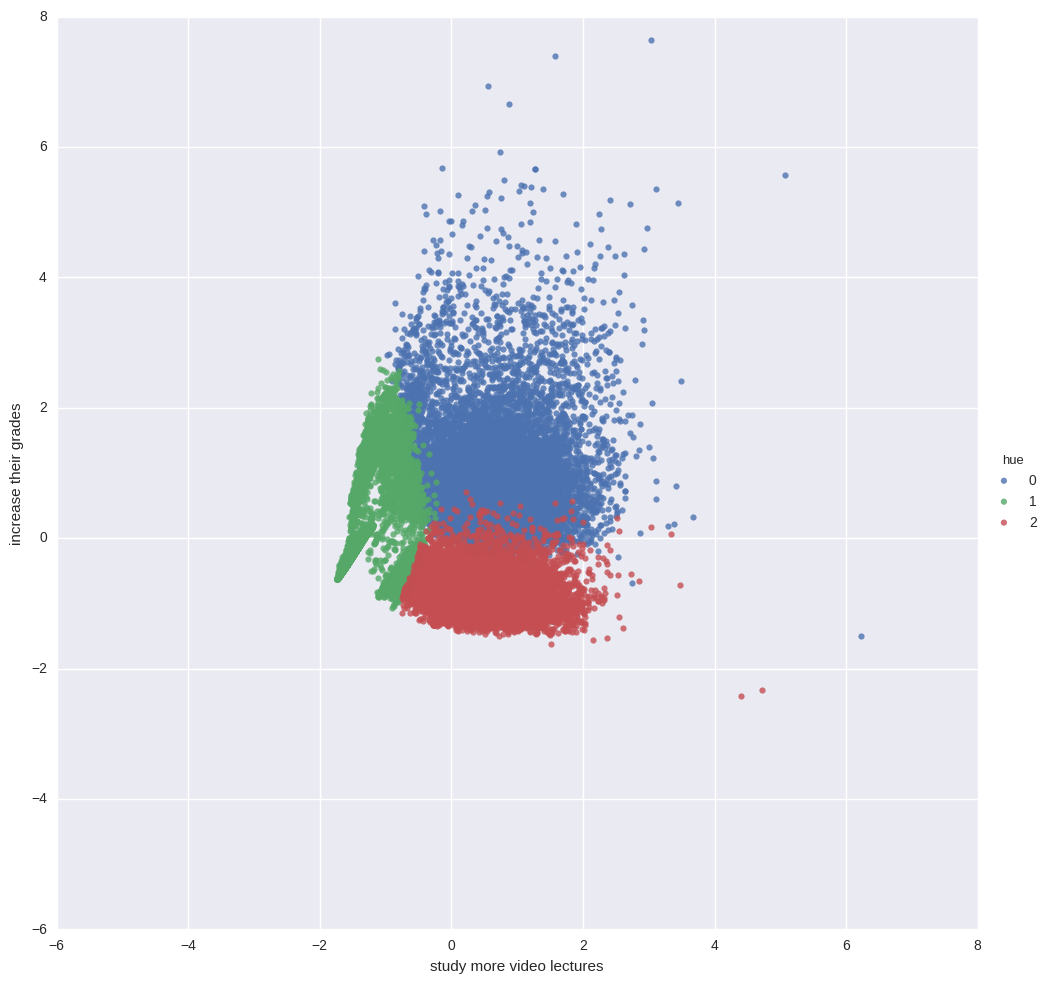

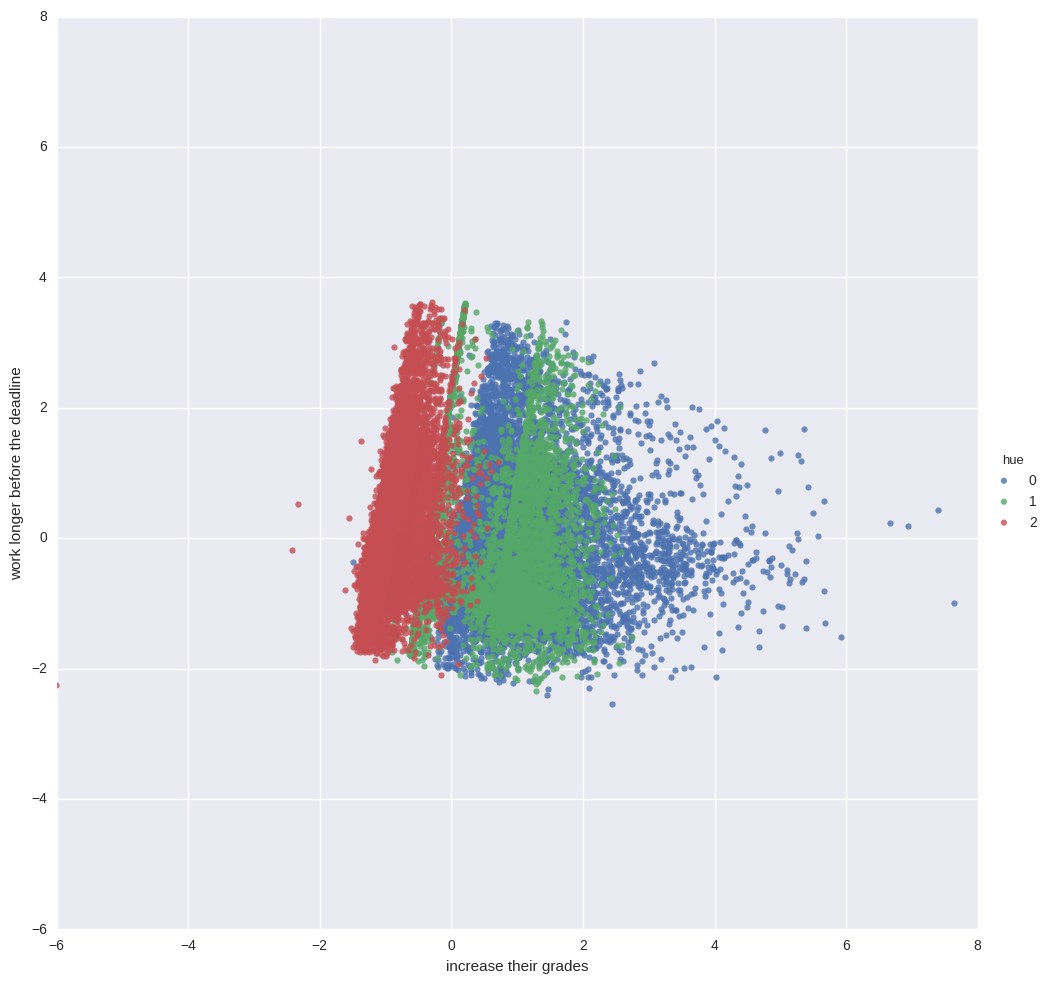

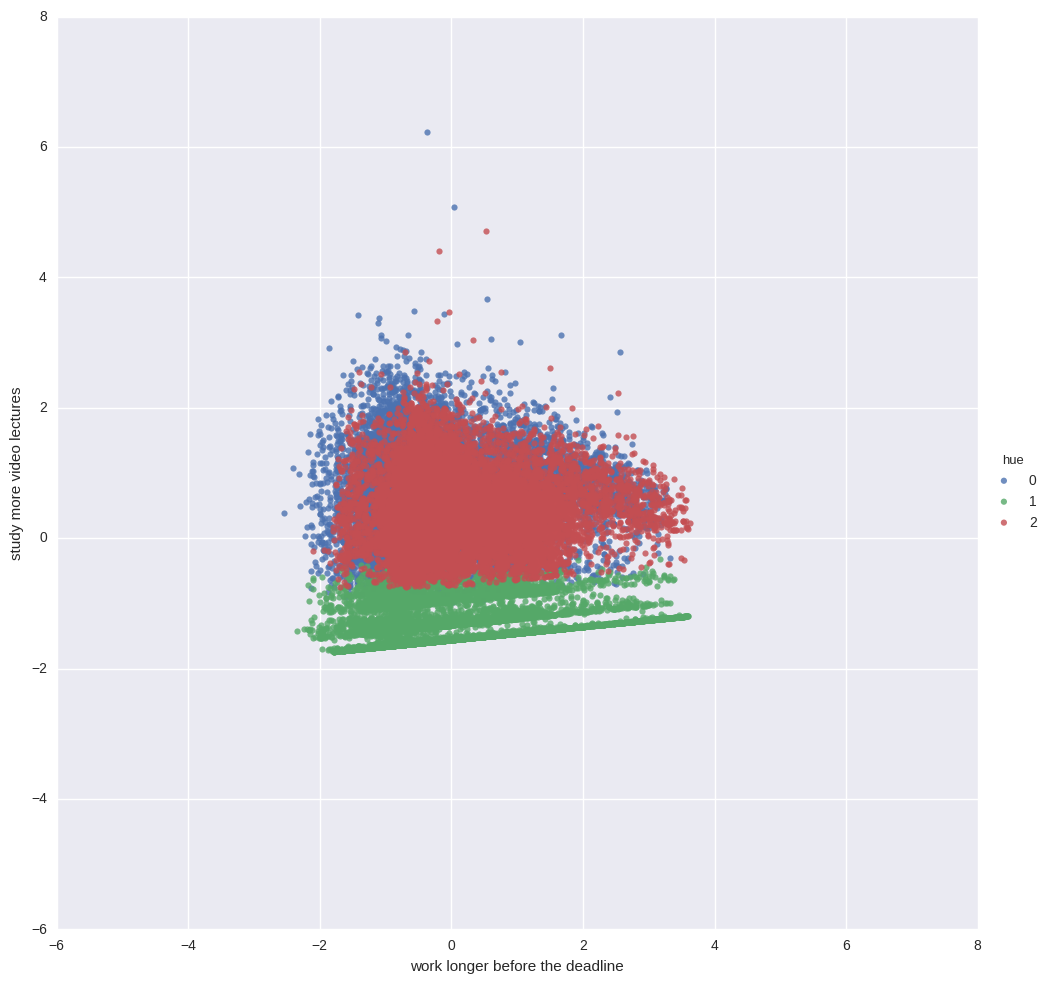

In [18]:
# plot against the two axis responsible of the most variance 
# put color as function of grade
#z = df[df.lastProblemGrade > outlierLimit].lastProblemGrade.values
#plt.figure(figsize=(20,8))

axisLabels = [
    'study more video lectures',
    'increase their grades',
    'work longer before the deadline'
]
l = [(0,1),(1,2),(2,0)]
for i, x in enumerate(l):
    data = pd.DataFrame({'x': X_New[:, x[0]], 'y': X_New[:, x[1]], 'hue': df_pca['labels'].values })
    sns.lmplot(x='x', y='y', hue='hue', data=data, fit_reg=False, size=10)
    plt.axis([-6, 8, -6, 8])
    plt.xlabel(axisLabels[x[0]])
    plt.ylabel(axisLabels[x[1]])

plt.show()